In [1]:
using Distributions
using PyPlot

In [183]:
# 多次元ガウス分布からのサンプリング
mu1 = Float64[2, 5]
mu2 = Float64[-3, 2]
sig = (fill(1.0, (2, 2)) + Diagonal([1, 1]))*0.3
x1 = rand(MvNormal(mu1, sig), 50)
x2 = rand(MvNormal(mu2, sig), 50)

mu3 = Float64[1, -5]
sig2 = Float64[1.5 1.0; 1.0 1.5]
x3 = rand(MvNormal(mu3, sig2), 100)

2×100 Array{Float64,2}:
  3.52423  -1.15255   2.99215   1.02359  …  -1.28458   0.37437   0.347085
 -1.47401  -5.7725   -3.65907  -4.26138     -6.64085  -4.87377  -6.01803 

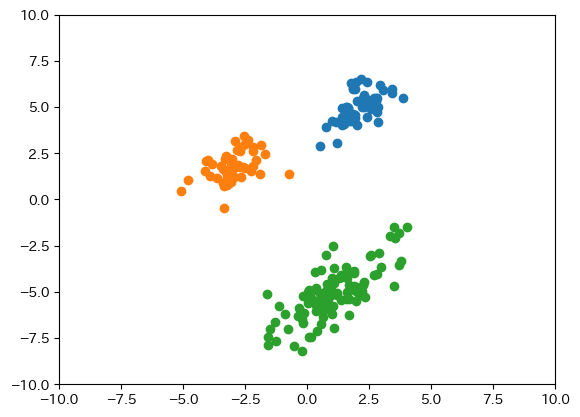

(-10, 10)

In [184]:
scatter(x1[1,:], x1[2,:])
scatter(x2[1,:], x2[2,:])
scatter(x3[1,:], x3[2,:])
xlim(-10, 10)
ylim(-10, 10)

## xyの相関がないガウス分布からサンプリングされるデータ（テスト用）

In [131]:
# 多次元ガウス分布からのサンプリング
mu1 = Float64[3, 5]
mu2 = Float64[-4, 2]
sig = (fill(1.0, (2, 2)) + Diagonal([1, 1]))*0.3
x1 = rand(MvNormal(mu1, sig), 50)
x2 = rand(MvNormal(mu2, sig), 50)

mu3 = Float64[1, -7]
sig2 = Float64[1.5 0.0; 0.0 1.5]
x3 = rand(MvNormal(mu3, sig2), 100)

2×100 Array{Float64,2}:
  1.00089   0.997215  -0.722223   0.997835  …  -1.99373   1.83739   0.294431
 -4.73346  -8.03417   -8.36575   -7.46561      -8.93242  -6.88448  -5.89919 

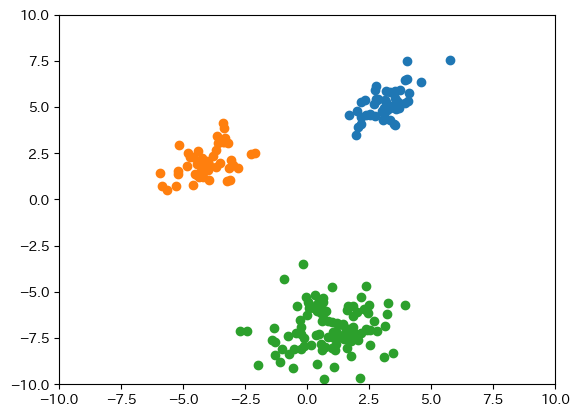

(-10, 10)

In [132]:
scatter(x1[1,:], x1[2,:])
scatter(x2[1,:], x2[2,:])
scatter(x3[1,:], x3[2,:])
xlim(-10, 10)
ylim(-10, 10)

## k-means
k-meansは、アルゴリズム的に局所解に陥るが、初期値によってどの程度影響があるのかを調べる。

In [4]:
function cal_err(X, Z, mu)
    N = size(X, 2)
    err = 0.0
    for i in 1:N
        z_i = Z[i]
        err += norm(X[:,i] - mu[:,z_i])
    end
    return err
end

cal_err (generic function with 1 method)

In [77]:
# クラスタ数と初期値
K = 3
mu = hcat(mu1, mu2, (mu1.+mu2)./2.0)
#mu = hcat(mu3.-0.5, mu3, mu3.+0.5)

X = hcat(hcat(x1, x2), x3)
N = size(X, 2)
D = ndims(X)

Z = zeros(Int64, N)

err = 10000.0
count = 0
while err > 420
    nk = zeros(K)
    for i in 1:N
        distances = [norm(mu[:, k] - X[:, i]) for k in 1:K]
        z_i = indmin(distances)
        Z[i] = z_i
        nk[z_i] += 1
    end
    for k in 1:K
        mu[:, k] = [sum(X[:, Z.==k][d,:])/nk[k] for d in 1:D]
    end
    err = cal_err(X, Z, mu)
    println(err)
end

LoadError: [91mUndefVarError: cal_err not defined[39m

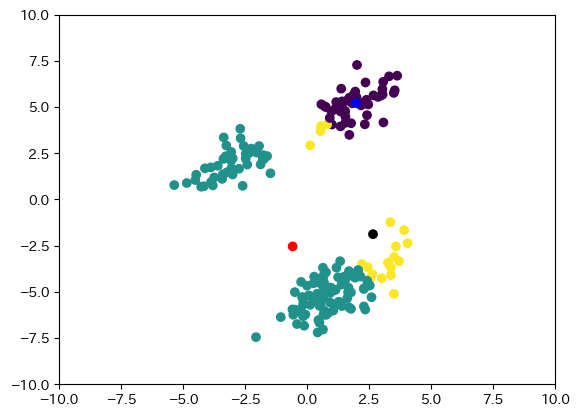

(-10, 10)

In [78]:
PyPlot.clf()
#X = hcat(hcat(x1, x2), x3)
#mu = hcat(mu1, mu2)
scatter(X[1,:], X[2,:], c=Z)
scatter(mu[1, :], mu[2, :], c=["blue", "red", "black"])
xlim(-10, 10)
ylim(-10, 10)

## 混合ガウス分布（分散固定ver）
ベイズ的に求めると、初期値の問題を解消できるのか検証

In [133]:
# 潜在変数をサンプリングするカテゴリカル分布のパラメータを求める関数
function cal_catparams(x, mu, K)
    D = size(mu,1)
    I = eye(D)
    p = zeros(K)
    for k in 1:K
        p[k] = pdf(MvNormal(mu[:,k], I), x)
    end
    return p./sum(p,1)
end

cal_catparams (generic function with 1 method)

In [134]:
# クラスタセンタをサンプリングするガウス分布のパラメータを求める関数
function cal_gaussparams(X, Z, k, nk, mu_0, sigma_0)
    N = size(X, 2)
    D = size(X,1)
    x_hat = zeros(D)
    for i in 1:N
        if(Z[i] == k)
            x_hat += X[:, i]
        end
    end
    return (x_hat + mu_0.*sigma_0^2)./(nk[k] + sigma_0^2), eye(D)./(nk[k] + sigma_0^2)
end

cal_gaussparams (generic function with 1 method)

In [167]:
# クラスタ数と初期値
K = 3
mu = hcat(mu1, mu2, (mu1.+mu2)./2.0)
#mu = hcat(mu3.-0.5, mu3, mu3.+0.5)
#mu = rand(MvNormal([0.0, 0.0], eye(2)), 3)
S = 5

X = hcat(hcat(x1, x2), x3)
N = size(X, 2)
D = ndims(X)
I = eye(D)

# ハイパーパラメータ
pi_0 = [1/K for _ in 1:K]
mu_0 = zeros(size(X, 1))
#mu_0 = mu3
sigma_0 = 1.0

Z = zeros(Int64, N)

for s in 1:S
    nk = zeros(K)
    log_likelihood = 0.0 
    
    for i in 1:N
        p = cal_catparams(X[:,i], mu, K)
        z_i = rand(Categorical(p), 1)[1]
        Z[i] = z_i
        nk[z_i] += 1
        log_likelihood += (pdf(MvNormal(mu[:,z_i], I), X[:, i]) + pdf(Categorical(pi_0), z_i))
    end
    for k in 1:K
        mu_hat, sig_hat = cal_gaussparams(X, Z, k, nk, mu_0, sigma_0)
        mu_k = rand(MvNormal(mu_hat, sig_hat), 1)
        mu[:,k] = mu_k
        log_likelihood += pdf(MvNormal(mu_0, (sigma_0^2).*I), mu_k)
    end
    println("log likelihood: ", log_likelihood)
end
        

log likelihood: [76.7318]
log likelihood: [75.3013]
log likelihood: [79.225]
log likelihood: [82.5003]
log likelihood: [82.4788]


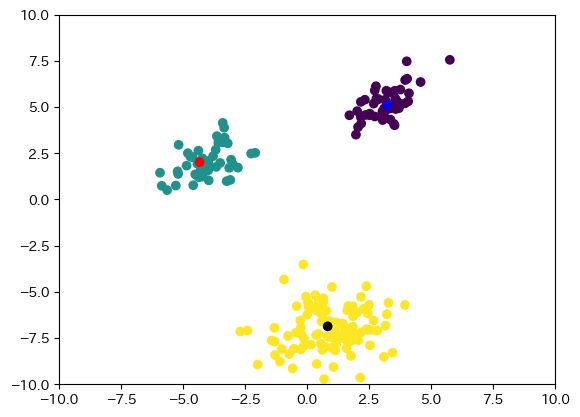

(-10, 10)

In [168]:
PyPlot.clf()
#X = hcat(hcat(x1, x2), x3)
#mu = hcat(mu1, mu2)
#mu = hcat(mu1, mu2, (mu1.+mu2)./2.0)
scatter(X[1,:], X[2,:], c=Z)
scatter(mu[1, :], mu[2, :], c=["blue", "red", "black"])
xlim(-10, 10)
ylim(-10, 10)

## k-meansと分散固定ガウス分布の比較

### 上に初期点を３つ並べ場合
パラメータを確率的に推定しているガウス分布でのクラスタリングの方が局所解に陥らないと思っていたが、結果は逆であった。  
~~ガウス分布の方が、上手くクラスタリングできないという結果になった。~~  
追記：何回か実行すると、上手く分類できる場合もあった。  
分散が固定であるため、クラスタセンタからある程度離れている点は殆どランダムになってしまうため、その点の影響でクラスタセンタが引っ張られてしまったと考えることができる。  
これは、分散も推定するようにすることで改善できるのでは無いかと考えられる。

### 下に初期点を３つ並べた場合
これは、どちらのアルゴリズムでも上手く分類できなかった。  

### 全体
どちらのアルゴリズムも初期点をランダムにすれば上手く学習できたので、何回か初期点を変えて値（k-meansではerr, 混合ガウスでは尤度）を見てどれにするかを判断するのが良い。  



# 混合ガウス分布（平均・分散どちらも変数）

In [169]:
# for sampling Latent Variable
function sampling_z(X, mu, tau, pi, K)
    N = size(X,2)
    Z = zeros(Int64, N)
    I = eye(size(X,1))
    for i in 1:N
        p = [pi[k] * pdf(MvNormal(mu[:, k], inv(tau).*I), X[:,i]) for k in 1:K]
        normalized_p = p./sum(p)
        Z[i] = rand(Categorical(normalized_p), 1)[1]
    end
    return Z
end


# calicurate mean and num of data for each cluster
function cal_cluster_stats(X, Z, K)
    N = size(X, 2)
    nks = zeros(K)
    xk_bars = zeros(size(X,1), K)
    for k in 1:K
        indices = find(Z.==k)
        nks[k] = length(indices)
        xk_bars[:, k] = sum(X[:, indices], 2)./nks[k]
    end
    return xk_bars, nks
end


# for sampling mean-params of mixtured gaussian
function sampling_mu(X, Z, tau, mu_0, rho_0, xk_bars, nks, K)
    N = size(X,2)
    I = eye(size(X, 1))
    mu = zeros(Float64, size(X,1), K)
    for k in 1:K
        mk = (nks[k].*xk_bars[k] +rho_0.*mu_0)./(nks[k] + rho_0)
        tau_k = tau * (nks[k] + rho_0)
        mu[:, k] = rand(MvNormal(mk, inv(tau_k) .* I), 1)
    end
    return mu
end


# for sampling variance-param of data and mean-distrib
function sampling_tau(X, Z, mu_0, rho_0, a_0, b_0, xk_bars, nks, K)
    N = size(X, 2)
    D = size(X, 1)
    a_n = a_0 + N * D * 0.5
    b_n = b_0
    cluster_var = 0.0
    
    for k in 1:K
        indices = find(Z .== k)
        cluster_var = sum([norm(X[:, idx] - xk_bars[k])^2 for idx in indices])
        b_n = b_n  + 0.5 * (cluster_var + (norm(xk_bars[k] - mu_0)^2) * ((nks[k] * rho_0)/(nks[k] + rho_0)))
    end
    tau = rand(Gamma(a_n, 1.0/b_n), 1)[1]
    return tau
end


# for sampling params of latent var's distrib
function sampling_pi(nks, alpha, K)
    alpha_hat = [nks[k] + alpha[k] for k in 1:K]
    pi = rand(Dirichlet(alpha_hat), 1)
    return pi
end


# caliculate log-likelihood of joint distrib
function cal_likelihood(X, Z, mu, tau, pi, mu_0, rho_0, a_0, b_0, alpha, K)
    N = size(X, 2)
    log_likelihood = pdf(Gamma(a_0, b_0), tau) + pdf(Dirichlet(alpha), pi)
    I = eye(size(X,1))
    for i in 1:N
        log_likelihood += (pdf(MvNormal(mu[:, Z[i]], inv(tau) .* I), X[:, i]) + pi[Z[i]])
    end
    for k in 1:K
        log_likelihood += pdf(MvNormal(mu_0, inv(tau * rho_0) .* I), mu[:, k])
    end
    return log_likelihood
end

cal_likelihood (generic function with 1 method)

In [187]:
#######
# data
X = hcat(hcat(x1, x2), x3)
N = size(X, 2)
D = ndims(X)
I = eye(D)


##########
# initialization
S =20
K = 3
#mu = hcat(mu1, mu2, (mu1.+mu2)./2.0)
#mu = hcat(mu3.-0.5, mu3, mu3.+0.5)
mu = rand(MvNormal([0.0, 0.0], eye(2)), K)
mu_0 = zeros(size(X, 1))
sigma_0 = 1.0
rho_0 = 1.0
a_0 = 1.0
b_0 = 1.0

pi = [1.0/float(K) for _ in 1:K]
tau = 1.0
alpha = [0.1 for _ in 1:K]

Z = zeros(Int64, N)

#########
# inference
for s in 1:S
    Z = sampling_z(X, mu, tau, pi, K)
    xk_bars, nks = cal_cluster_stats(X, Z, K)
    mu = sampling_mu(X, Z, tau, mu_0, rho_0, xk_bars, nks, K)
    tau = sampling_tau(X, Z, mu_0, rho_0, a_0, b_0, xk_bars, nks, K)
    pi = sampling_pi(nks, alpha, K)
    likelihood = cal_likelihood(X, Z, mu, tau, pi, mu_0, rho_0, a_0, b_0, alpha, K)
    println("s: $s, likelihood: $likelihood")
end

s: 1, likelihood: [75.0824]
s: 2, likelihood: [72.1076]
s: 3, likelihood: [78.3974]
s: 4, likelihood: [80.5424]
s: 5, likelihood: [79.1624]
s: 6, likelihood: [73.6256]
s: 7, likelihood: [78.22]
s: 8, likelihood: [82.0646]
s: 9, likelihood: [73.3591]
s: 10, likelihood: [73.7811]
s: 11, likelihood: [80.3534]
s: 12, likelihood: [79.347]
s: 13, likelihood: [82.5161]
s: 14, likelihood: [87.5784]
s: 15, likelihood: [86.0073]
s: 16, likelihood: [84.0163]
s: 17, likelihood: [82.258]
s: 18, likelihood: [79.7946]
s: 19, likelihood: [79.6889]
s: 20, likelihood: [80.9432]


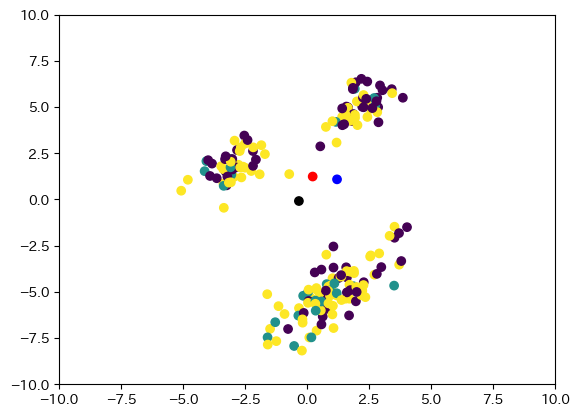

(-10, 10)

In [188]:
# plotting result
PyPlot.clf()
#X = hcat(hcat(x1, x2), x3)
#mu = hcat(mu1, mu2)
#mu = hcat(mu1, mu2, (mu1.+mu2)./2.0)
scatter(X[1,:], X[2,:], c=Z)
scatter(mu[1, :], mu[2, :], c=["blue", "red", "black"])
xlim(-10, 10)
ylim(-10, 10)

## まとめ
うまく分布を推論できていない。  
プログラムが間違っているのか、分散が全てのガウス分布で同じになっているのがいけないのか。  
個人的には、後者であると思うのだが...

In [20]:
find(Z.%2 .== 0)

4-element Array{Int64,1}:
 1
 3
 5
 7

In [33]:
Z[Z .%2 .== 0]

4-element Array{Int64,1}:
 0
 2
 4
 6

In [25]:
a = [1 2 3; 4 5 6; 7 8 9]

3×3 Array{Int64,2}:
 1  2  3
 4  5  6
 7  8  9

In [34]:
b = [1; 1; 1]

3-element Array{Int64,1}:
 1
 1
 1

In [37]:
c = [2; 3; 4]

3-element Array{Int64,1}:
 2
 3
 4

In [38]:
dot(c, b)

9

In [31]:
a + b

2-element Array{Int64,1}:
 3
 6